In [2]:
%load_ext autoreload
%autoreload 2

import remeta
import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.colors import LinearSegmentedColormap
from remeta.gendata import simulate

from remeta.plot import set_fontsize
from remeta.transform import type1_evidence_to_confidence

In [17]:
np.random.seed(1)

params = dict(
    type1_noise=0.2,
    type2_evidence_bias=1,
    type2_noise=0.2
)

params_sweep = dict(
    type2_evidence_bias=[0.5, 0.75, 1, 1/0.75, 1/0.5][::-1],
    type2_noise=[0.05, 0.1, 0.2, 0.4, 0.8],
    type1_noise=[0.1, 0.2, 0.4, 0.8, 1.6]
)

# meta_noise_type = 'readout'
type2_noise_type = 'report'
type2_noise_dist = dict(report='truncated_norm_mode', readout='truncated_norm_mode', temperature='truncated_norm_mode')[type2_noise_type]

titles = dict(
    type2_confidence_bias=r'Metacognitive confidence bias $\alpha_2$',
    type2_evidence_bias=r'Metacognitive evidence bias $\varphi_2$',
    type2_noise=r'Type 2 noise $\sigma_2$',
    type1_noise=r'Type 1 noise $\sigma_1$'
)
symbols = dict(type2_confidence_bias=r'$\alpha_2$', type2_evidence_bias=r'$\varphi_2$', type2_noise=r'$\sigma_2$', type1_noise=r'$\sigma_1$')

cmap = LinearSegmentedColormap.from_list('bg', [(0.8, 0.3, 0.3), (0.3, 0.3, 0.3), (0.3, 0.3, 0.8)], N=5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

max_DV = 0.8
bs = 0.02
xrange = np.arange(bs, max_DV+bs, bs)

cfg = remeta.Configuration()
cfg.type2_noise_type = type2_noise_type
cfg.param_type2_noise.distribution = type2_noise_dist
cfg.param_type2_criteria.enable = 0

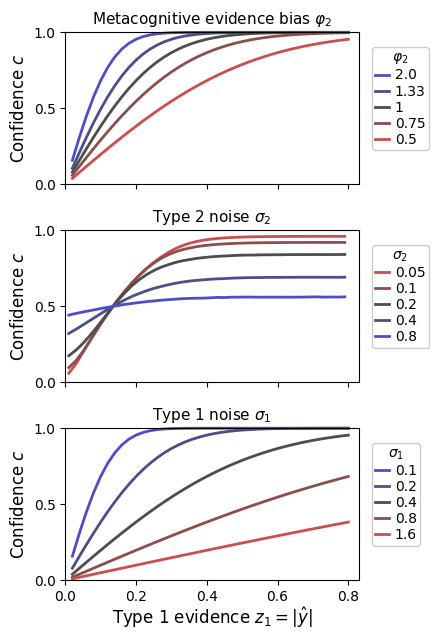

In [3]:
nsubjects = 100
N = 100000

plt.figure(figsize=(4.5, 6.5))
nsubplots = len(params_sweep)
axes = [None] * nsubplots
for i, param in enumerate(params_sweep):
    ax = plt.subplot(nsubplots, 1, i + 1)
    axes[i] = ax

    for j in range(len(params_sweep[param])):
        params_ = {**params, **{param: params_sweep[param][j]}}
        if param == 'type2_noise':
            m = simulate(
                nsubjects=nsubjects, nsamples=N, params=params_, stim_levels=100,
                verbosity=0, cfg=cfg
            )
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', RuntimeWarning)
                confidence_av = np.array([np.nanmean(m.confidence[(np.abs(m.y_decval) >= v - bs) & (np.abs(m.y_decval) < v)]) for v in xrange])
            plt.plot(xrange-bs/2, confidence_av, '-', color=cmap(j), zorder=10, clip_on=False, label=str(params_sweep[param][j]).replace('-', '−'), lw=2)
        else:
            label = '1.33' if params_sweep[param][j] == 4/3 else str(params_sweep[param][j]).replace('-', '−')
            plt.plot(xrange, type1_evidence_to_confidence(xrange, **params_), color=cmap(4-j) if i < 4 else cmap(j), clip_on=False, label=label, lw=2)

    set_fontsize(label=14, tick=13)

    xticks = np.arange(0, 1.1, 0.2)
    yticks = np.arange(0, 1.05, 0.5)
    if i < 2:
        plt.xticks(xticks, [])
    else:
        plt.xlabel(r'Type 1 evidence $z_1=|\hat{y}|$', labelpad=1)
        plt.xticks(xticks)
    plt.ylabel(r'Confidence $c$')
    plt.yticks(yticks)

    set_fontsize(label=12, tick=10)
    leg = plt.legend(bbox_to_anchor=(0.7, 0.05), loc="upper left", fontsize=9)
    plt.legend(title=symbols[param], bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=0.15, handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25)

    plt.title(titles[param], fontsize=11)
    plt.xlim((0, 0.83))
    plt.ylim((0, 1.0))


plt.tight_layout()
plt.savefig('../content/img/type2_parameters.png', bbox_inches='tight', pad_inches=0.02)
# plt.subplots_adjust(wspace=0.4, hspace=0.34, bottom=0.2, top=0.91)
plt.show()


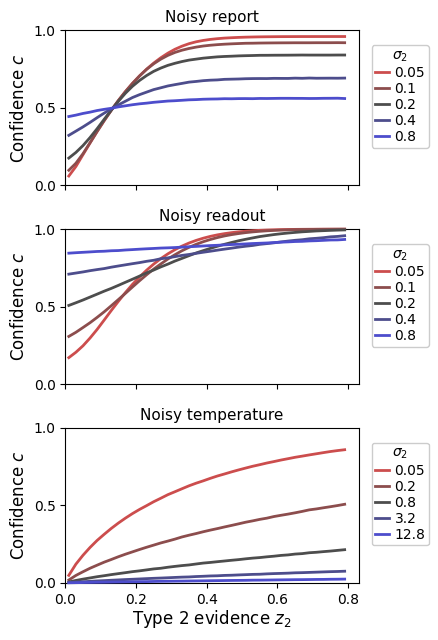

In [4]:
nsubjects = 100
N = 100000

params_sweep_type2_noise = dict(
    report=[0.05, 0.1, 0.2, 0.4, 0.8],
    readout=[0.05, 0.1, 0.2, 0.4, 0.8],
    temperature=[0.05, 0.2, 0.8, 3.2, 12.8]
)

param = 'type2_noise'

cfg.type2_noise_dist = type2_noise_dist
cfg.param_type2_criteria.enable = 0

noise_typs = ['report', 'readout', 'temperature']

plt.figure(figsize=(4.5, 6.5))
nsubplots = len(noise_typs)
axes = [None] * nsubplots
for i, typ in enumerate(noise_typs):
    ax = plt.subplot(nsubplots, 1, i + 1)
    axes[i] = ax

    cfg.type2_noise_type = typ

    for j in range(len(params_sweep[param])):
        params_ = {**params, **{param: params_sweep_type2_noise[typ][j] * (10 if typ == 'temperature' else 1)}}
        m = simulate(
            nsubjects=nsubjects, nsamples=N, params=params_, stim_levels=100,
            verbosity=0, cfg=cfg
        )
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', RuntimeWarning)
            confidence_av = np.array([np.nanmean(m.confidence[(np.abs(m.y_decval) >= v - bs) & (np.abs(m.y_decval) < v)]) for v in xrange])
        plt.plot(xrange-bs/2, confidence_av, '-', color=cmap(j), zorder=10, clip_on=False, label=str(params_sweep_type2_noise[typ][j]).replace('-', '−'), lw=2)

    set_fontsize(label=14, tick=13)

    xticks = np.arange(0, 1.1, 0.2)
    yticks = np.arange(0, 1.05, 0.5)
    if i < 2:
        plt.xticks(xticks, [])
    else:
        plt.xlabel(r'Type 2 evidence $z_2$', labelpad=1)
        plt.xticks(xticks)
    plt.ylabel(r'Confidence $c$')
    plt.yticks(yticks)

    set_fontsize(label=12, tick=10)
    leg = plt.legend(bbox_to_anchor=(0.7, 0.05), loc="upper left", fontsize=9)
    plt.legend(title=symbols[param], bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=0.15, handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25)

    plt.title(f'Noisy {typ}', fontsize=11)
    plt.xlim((0, 0.83))
    plt.ylim((0, 1.0))


plt.tight_layout()
plt.savefig('../content/img/type2_parameters_noise.png', bbox_inches='tight', pad_inches=0.02)
# plt.subplots_adjust(wspace=0.4, hspace=0.34, bottom=0.2, top=0.91)
plt.show()



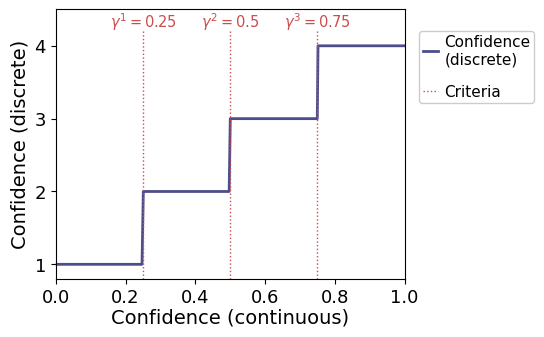

In [12]:
max_conf = 1
bs_fine = 0.001
xrange_fine = np.arange(bs_fine, max_conf+bs_fine, bs_fine)

criteria = [0.25, 0.5, 0.75]


plt.figure(figsize=(4.5, 3.5))

c_conf = type1_evidence_to_confidence(xrange_fine, **params)
c_conf_discrete = np.digitize(c_conf, criteria) + 1

plt.plot(c_conf, c_conf_discrete, color=cmap(3), clip_on=False, label='Confidence\n(discrete)', lw=2)
for i, crit in enumerate(criteria):
    plt.plot([crit, crit], [0.8, len(criteria)+1.2], color=cmap(0), ls=':', clip_on=False, lw=1,label='Criteria' if i == 0 else None)
    plt.text(crit, len(criteria)+1.25, rf'$\gamma^{i+1}={crit}$', fontsize=10.5, ha='center', color=cmap(0))

xticks = np.arange(0, 1.1, 0.2)
yticks = np.arange(1, len(criteria)+2, 1)

plt.xlabel(r'Confidence (continuous)', labelpad=1)
plt.xticks(xticks)
plt.ylabel(r'Confidence (discrete)')
plt.yticks(yticks)

plt.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=1.15, handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25, fontsize=11)

# plt.title(f'Noisy {typ}', fontsize=11)
plt.xlim((0, max_conf))
plt.ylim((0.8, len(criteria)+1.5))


set_fontsize(label=14, tick=13)


plt.savefig('../content/img/type2_parameters_criteria.png', bbox_inches='tight', pad_inches=0.02)
# plt.subplots_adjust(wspace=0.4, hspace=0.34, bottom=0.2, top=0.91)
plt.show()



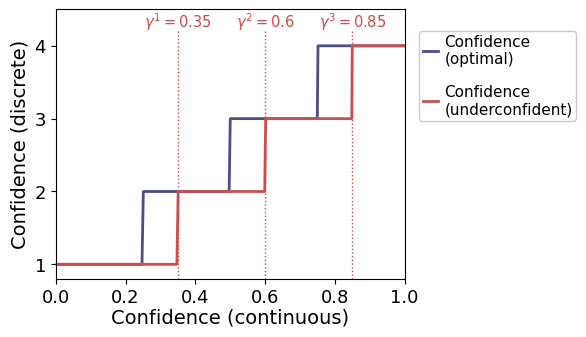

In [6]:
max_conf = 1
bs_fine = 0.001
xrange_fine = np.arange(bs_fine, max_conf+bs_fine, bs_fine)

criteria = np.array([0.25, 0.5, 0.75])
criteria_under = criteria + 0.1

plt.figure(figsize=(4.5, 3.5))

c_conf = type1_evidence_to_confidence(xrange_fine, **params)
c_conf_discrete = np.digitize(c_conf, criteria) + 1
c_conf_discrete_under = np.digitize(c_conf, criteria_under) + 1

plt.plot(c_conf, c_conf_discrete, color=cmap(3), clip_on=False, label='Confidence\n(optimal)', lw=2)
plt.plot(c_conf, c_conf_discrete_under, color=cmap(0), clip_on=False, label='Confidence\n(underconfident)', lw=2)

for i, crit in enumerate(criteria_under):
    plt.plot([crit, crit], [0.8, len(criteria)+1.2], color=cmap(0), ls=':', clip_on=False, lw=1)
    plt.text(crit, len(criteria)+1.25, rf'$\gamma^{i+1}={crit}$', fontsize=10.5, ha='center', color=cmap(0))

xticks = np.arange(0, 1.1, 0.2)
yticks = np.arange(1, len(criteria)+2, 1)

plt.xlabel(r'Confidence (continuous)', labelpad=1)
plt.xticks(xticks)
plt.ylabel(r'Confidence (discrete)')
plt.yticks(yticks)

# plt.title(f'Noisy {typ}', fontsize=11)
plt.xlim((0, max_conf))
plt.ylim((0.8, len(criteria)+1.5))

plt.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=1.15, handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25, fontsize=11)

set_fontsize(label=14, tick=13)


plt.savefig('../content/img/type2_parameters_criteria_underconfident.png', bbox_inches='tight', pad_inches=0.02)
# plt.subplots_adjust(wspace=0.4, hspace=0.34, bottom=0.2, top=0.91)
plt.show()



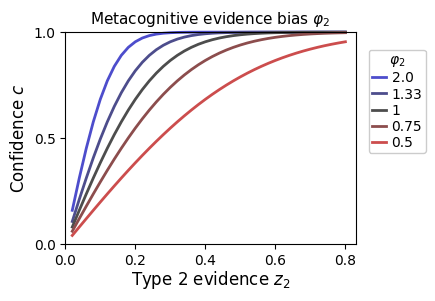

In [7]:
params_sweep_bias = dict(
    type2_evidence_bias=[0.5, 0.75, 1, 1/0.75, 1/0.5][::-1],
)

# type2_criteria = np.array([0.25, 0.5, 0.75])
type2_criteria = np.arange(0.001, 1.001, 0.001)

plt.figure(figsize=(3.75, 2.75))
nsubplots = len(params_sweep_bias)

param = 'type2_evidence_bias'

for j in range(len(params_sweep_bias[param])):

    params_ = {**params, **{param: params_sweep_bias[param][j]}}

    label = '1.33' if params_sweep_bias[param][j] == 4/3 else str(params_sweep_bias[param][j]).replace('-', '−')
    c_conf = type1_evidence_to_confidence(xrange, **params_)

    plt.plot(xrange, c_conf, color=cmap(4-j) if i < 4 else cmap(j), clip_on=False, label=label, lw=2)

set_fontsize(label=14, tick=13)

xticks = np.arange(0, 1.1, 0.2)
yticks = np.arange(0, 1.05, 0.5)

plt.xlabel(r'Type 2 evidence $z_2$', labelpad=1)
plt.xticks(xticks)
plt.ylabel(r'Confidence $c$')
plt.yticks(yticks)

set_fontsize(label=12, tick=10)
leg = plt.legend(bbox_to_anchor=(0.7, 0.05), loc="upper left", fontsize=9)
plt.legend(
    title=r'$\Delta\gamma_i$' if param == 'type2_criteria' else symbols[param],
    bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=0.15,
    handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25
)

plt.title(r'Criterion bias $\Delta\gamma_i$' if param == 'type2_criteria' else titles[param], fontsize=11)
plt.xlim(0, 0.83)
plt.ylim(0, 1)

plt.savefig('../content/img/type2_parameters_evidence_bias.png', bbox_inches='tight', pad_inches=0.02)
# plt.subplots_adjust(wspace=0.4, hspace=0.34, bottom=0.2, top=0.91)
plt.show()


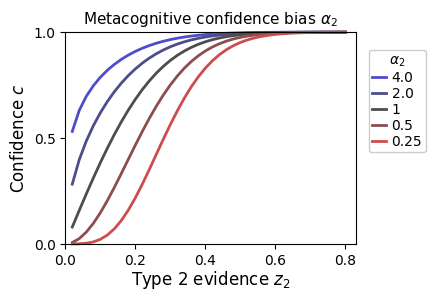

In [8]:
params_sweep_bias = dict(
    type2_confidence_bias=[0.25, 0.5, 1, 1/0.5, 1/0.25][::-1]
)

# type2_criteria = np.array([0.25, 0.5, 0.75])
type2_criteria = np.arange(0.001, 1.001, 0.001)

plt.figure(figsize=(3.75, 2.75))
nsubplots = len(params_sweep_bias)

param = 'type2_confidence_bias'

for j in range(len(params_sweep_bias[param])):

    params_ = {**params, **{param: params_sweep_bias[param][j]}}

    label = '1.33' if params_sweep_bias[param][j] == 4/3 else str(params_sweep_bias[param][j]).replace('-', '−')
    c_conf = type1_evidence_to_confidence(xrange, **params_)

    plt.plot(xrange, c_conf, color=cmap(4-j) if i < 4 else cmap(j), clip_on=False, label=label, lw=2)

set_fontsize(label=14, tick=13)

xticks = np.arange(0, 1.1, 0.2)
yticks = np.arange(0, 1.05, 0.5)

plt.xlabel(r'Type 2 evidence $z_2$', labelpad=1)
plt.xticks(xticks)
plt.ylabel(r'Confidence $c$')
plt.yticks(yticks)

set_fontsize(label=12, tick=10)
leg = plt.legend(bbox_to_anchor=(0.7, 0.05), loc="upper left", fontsize=9)
plt.legend(
    title=r'$\Delta\gamma_i$' if param == 'type2_criteria' else symbols[param],
    bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=0.15,
    handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25
)

plt.title(r'Criterion bias $\Delta\gamma_i$' if param == 'type2_criteria' else titles[param], fontsize=11)
plt.xlim(0, 0.83)
plt.ylim(0, 1)

plt.savefig('../content/img/type2_parameters_confidence_bias.png', bbox_inches='tight', pad_inches=0.02)
# plt.subplots_adjust(wspace=0.4, hspace=0.34, bottom=0.2, top=0.91)
plt.show()


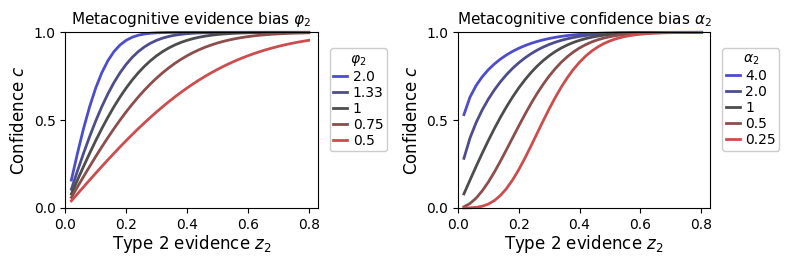

In [9]:
params_sweep_bias = dict(
    type2_evidence_bias=[0.5, 0.75, 1, 1/0.75, 1/0.5][::-1],
    type2_confidence_bias=[0.25, 0.5, 1, 1/0.5, 1/0.25][::-1]
)

# type2_criteria = np.array([0.25, 0.5, 0.75])
type2_criteria = np.arange(0.001, 1.001, 0.001)

plt.figure(figsize=(8, 2.75))
nsubplots = len(params_sweep_bias)
axes = [None] * nsubplots
for i, param in enumerate(params_sweep_bias):
    ax = plt.subplot(1, nsubplots, i + 1)
    axes[i] = ax

    for j in range(len(params_sweep_bias[param])):
        params_ = {**params, **{param: params_sweep_bias[param][j]}}

        label = '1.33' if params_sweep_bias[param][j] == 4/3 else str(params_sweep_bias[param][j]).replace('-', '−')
        c_conf = type1_evidence_to_confidence(xrange, **params_)
        plt.plot(xrange, c_conf, color=cmap(4-j) if i < 4 else cmap(j), clip_on=False, label=label, lw=2)

    set_fontsize(label=14, tick=13)

    xticks = np.arange(0, 1.1, 0.2)
    yticks = np.arange(0, 1.05, 0.5)

    plt.xlabel(r'Type 2 evidence $z_2$', labelpad=1)
    plt.xticks(xticks)
    plt.ylabel(r'Confidence $c$')
    plt.yticks(yticks)

    set_fontsize(label=12, tick=10)
    leg = plt.legend(bbox_to_anchor=(0.7, 0.05), loc="upper left", fontsize=9)
    plt.legend(
        title=symbols[param],
        bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=0.15,
        handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25
    )

    plt.title(titles[param], fontsize=11)
    plt.xlim((0, 0.83))
    plt.ylim((0, 1.0))


plt.tight_layout()
plt.savefig('../content/img/type2_parameters_biases.png', bbox_inches='tight', pad_inches=0.02)
# plt.subplots_adjust(wspace=0.4, hspace=0.34, bottom=0.2, top=0.91)
plt.show()


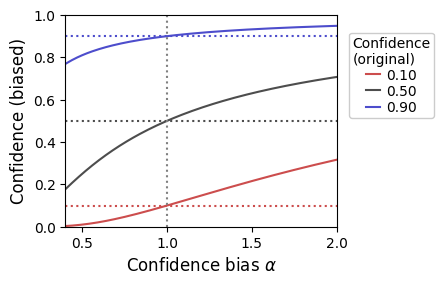

In [10]:
alpha = np.linspace(0.01, 100, 10000)
cs = [0.1, 0.5, 0.9]
plt.figure(figsize=(3.5, 2.75))
for i, c in enumerate(cs):
    plt.plot(alpha, np.pow(c, 1/alpha), color=cmap(i*2), label=f'{c:.2f}')
    plt.plot([10e-3, 2], [c, c], color=cmap(i*2), ls=':')
plt.plot([1, 1], [0, 1], ':', color='grey')
plt.ylim(0, 1)
# plt.xscale("log")
# plt.xlim(10e-3, 10e1)
plt.xlim(0.4, 2)
plt.xlabel(r'Confidence bias $\alpha$')
plt.ylabel('Confidence (biased)')
plt.legend(
    title='Confidence\n(original)',
    bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=0.15,
    handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25
)
set_fontsize(label=12, tick=10)
plt.savefig('../content/img/type2_parameters_confidence_bias_trans.png', bbox_inches='tight', pad_inches=0.02)


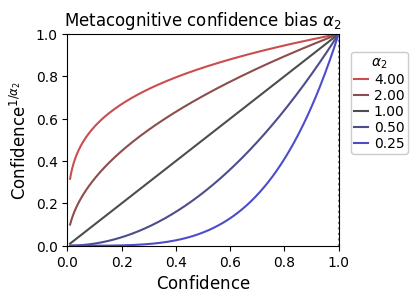

In [27]:
c_conf = np.linspace(0.01, 1, 1000)
type2_confidence_biases = [0.25, 0.5, 1, 1/0.5, 1/0.25][::-1]
# type2_confidence_biases = [1/3, 2/3, 1, 4/3, 5/3][::-1]
plt.figure(figsize=(3.5, 2.75))
for i, bias in enumerate(type2_confidence_biases):
    plt.plot(c_conf, np.pow(c_conf, 1/bias), color=cmap(i), label=f'{bias:.2f}')
    # plt.plot(c_conf, np.pow(c_conf, 1/np.log((np.e-1)*bias +1)), color=cmap(i), label=f'{bias:.2f}')
    # plt.plot([10e-3, 2], [c, c], color=cmap(i*2), ls=':')
plt.plot([1, 1], [0, 1], ':', color='grey')
plt.ylim(0, 1)
# plt.xscale("log")
# plt.xlim(10e-3, 10e1)
plt.xlim(0, 1)
plt.xlabel(r'$\text{Confidence}$')
plt.ylabel(r'$\text{Confidence}^{1/\alpha_2}$')
plt.legend(
    title=r'$\alpha_2$',
    bbox_to_anchor=(1.02, 0.95), loc='upper left', framealpha=1, labelspacing=0.15,
    handlelength=1, handletextpad=0.4, columnspacing=0.3, borderpad=0.25
)
plt.title(fr'Metacognitive confidence bias $\alpha_2$')
set_fontsize(label=12, tick=10)
plt.savefig('../content/img/type2_parameters_confidence_bias_trans2.png', bbox_inches='tight', pad_inches=0.02)


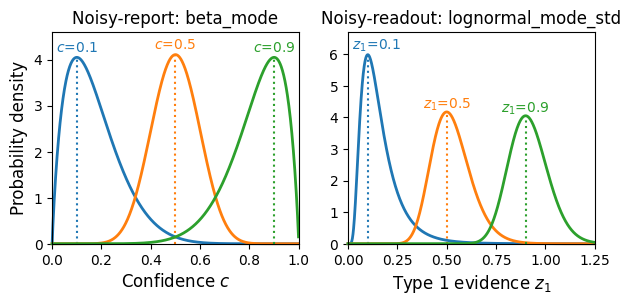

In [54]:
plt.figure(figsize=(7, 2.75))

plt.subplot(121)
x = np.arange(0, 1, 0.001)
for i, center in enumerate([0.1, 0.5, 0.9]):
    dist = remeta.type2_dist.get_type2_dist('beta_mode', type2_center=center, type2_noise=0.1, type2_noise_type='report')
    y = dist.pdf(x)
    plt.plot(x, y, clip_on=False, color=colors[i], lw=2)
    plt.plot([center, center], [0, dist.pdf(center)], clip_on=False, color=colors[i], ls=':')
    plt.text(center, dist.pdf(center)*1.03, f'$c$={center:.1g}', fontsize=10, ha='center', color=colors[i])
plt.xlabel('Confidence $c$')
plt.ylabel('Probability density')
plt.xlim(0, 1)
plt.ylim(0, 4.6)
plt.title('Noisy-report: beta_mode')

plt.subplot(122)
x = np.arange(0, 1.25, 0.001)
for i, center in enumerate([0.1, 0.5, 0.9]):
    dist = remeta.type2_dist.get_type2_dist('lognormal_mode_std', type2_center=center, type2_noise=0.1, type2_noise_type='readout')
    y = dist.pdf(x)
    plt.plot(x, y, clip_on=False, color=colors[i], lw=2)
    plt.plot([center, center], [0, dist.pdf(center)], clip_on=False, color=colors[i], ls=':')
    plt.text(center, dist.pdf(center)*1.03, f'    $z_1$={center:.1g}' if i == 0 else f'$z_1$={center:.1g}', fontsize=10, ha='center', color=colors[i])
plt.xlabel('Type 1 evidence $z_1$')
plt.xlim(0, 1.25)
plt.ylim(0, 6.7)
plt.title('Noisy-readout: lognormal_mode_std')

set_fontsize(label=12, tick=10)
plt.savefig('../content/img/type2_noise_dist.png', bbox_inches='tight', pad_inches=0.02)